# **Minibatch for DUTS-TR & DUTS-TE Datasets**

In [1]:
# Pkg.add("Knet")

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


In [2]:
using Colors, Images, Knet

In [3]:
img_path = "Data/DUTS/DUTS-TR/DUTS-TR-Image/ILSVRC2012_test_00000004.jpg"
img = load(img_path)

mask_path = "Data/DUTS/DUTS-TR/DUTS-TR-Mask/ILSVRC2012_test_00000004.png"
mask = load(mask_path);

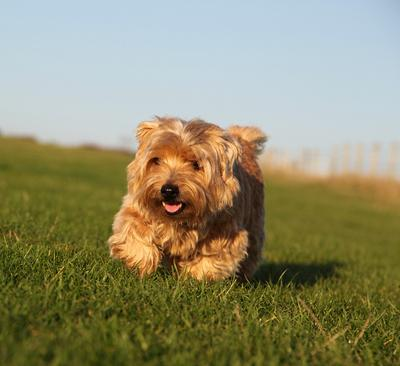

In [4]:
img

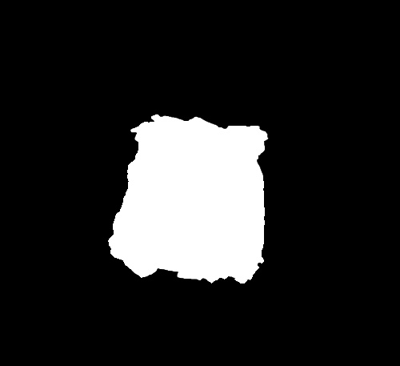

In [5]:
mask

In [6]:
train_image_paths = split(read(`ls -1v Data/DUTS/DUTS-TR/DUTS-TR-Image`, String));
train_mask_paths = split(read(`ls -1v Data/DUTS/DUTS-TR/DUTS-TR-Mask`, String));

test_image_paths = split(read(`ls -1v Data/DUTS/DUTS-TE/DUTS-TE-Image`, String));
test_mask_paths = split(read(`ls -1v Data/DUTS/DUTS-TE/DUTS-TE-Mask`, String));

train_image_paths = ["Data/DUTS/DUTS-TR/DUTS-TR-Image/"*i for i in train_image_paths]
train_mask_paths = ["Data/DUTS/DUTS-TR/DUTS-TR-Mask/"*i for i in train_mask_paths]

test_image_paths = ["Data/DUTS/DUTS-TE/DUTS-TE-Image/"*i for i in test_image_paths]
test_mask_paths = ["Data/DUTS/DUTS-TE/DUTS-TE-Mask/"*i for i in test_mask_paths];

In [41]:
function minibatch(x, y, bs=16)
    data = Any[]
    n_instances = length(x)
    n_batches = n_instances / bs
    for batch = 1:4
        xbatch = Any[]
        ybatch = Any[]
        
        bs_range = batch == n_batches ?  n_instances-n_batches*bs : bs
        for sample = 1:bs_range
            img = imresize(load(x[bs * (batch-1) + sample]), (224, 224, 3, 1))
            img = KnetArray((Float64.(channelview(img))).*255)
            mask = imresize(load(y[bs * (batch-1) + sample]), (224, 224))
            mask = KnetArray((Float64.(channelview(mask))).*255)
            push!(xbatch, img);
            push!(ybatch, mask);
            # push!(ybatch, load(y[bs * (batch-1) + sample]));
        end
        push!(data,(xbatch,ybatch))
    end
    return data
end

minibatch (generic function with 2 methods)

In [103]:
function minibatch_2(x, y, bs=16)
    X = 0
    Y = 0
    first = true
    
    n_samples = 0
    
    for (path_x, path_y) in zip(x, y)
        if n_samples < bs
            n_samples += 1
            img = load(path_x)
            img = channelview(img)
            img = convert(Array{Float32},img)
            img = imresize(img,(224,224,3))

            mask = load(path_y)
            mask = channelview(mask)
            mask = convert(Array{Float32},mask)
            mask = imresize(mask,(224,224))

            if first == false
                X = cat(img, X, dims=4)
                Y = cat(mask, Y, dims=3)
            else
                X = cat(img, dims=4)
                Y = cat(mask, dims=3)
            end
            first = false
        end
    end
    println("--",size(X))
    println("--",size(Y))
    return x, y
end

minibatch_2 (generic function with 2 methods)

In [104]:
# train_dataloader = minibatch(train_image_paths, train_mask_paths);
# test_dataloader = minibatch(test_image_paths, train_mask_paths);

x_train, y_train = minibatch_2(train_image_paths, train_mask_paths);
x_test, y_test = minibatch_2(test_image_paths, test_mask_paths);

--(224, 224, 3, 16)
--(224, 224, 16)
--(224, 224, 3, 16)
--(224, 224, 16)


# **Baseline CNN Model**

In [45]:
println("GPU: ", replace(read(`nvidia-smi --query-gpu=name --format=csv,noheader`,String),'\n'=>", "))
println("Knet: ", Pkg.dependencies()[Base.UUID("1902f260-5fb4-5aff-8c31-6271790ab950")].version)


GPU: NVIDIA GeForce GTX 1650, 
Knet: 1.4.8


In [46]:
function initmodel(; atype=KnetArray, dtype=Float32, winit=xavier, binit=zeros)
    w(dims...)=atype(winit(dtype,dims...))
    b(dims...)=atype(binit(dtype,dims...))
    return Any[
        w(3,3,3,50), b(1,1,50,1),
        w(3,3,50,50), b(1,1,50,1),
        w(3,3,50,100), b(1,1,100,1),
        w(3,3,100,100), b(1,1,100,1),
        w(1, 1, 100, 1), b(1, 1, 1, 1)
    ]
end;

In [80]:
initmodel()

10-element Vector{Any}:
 K32(3,3,3,50)[-0.085760534⋯]
 K32(1,1,50,1)[0.0⋯]
 K32(3,3,50,50)[-0.016453236⋯]
 K32(1,1,50,1)[0.0⋯]
 K32(3,3,50,100)[-0.033971917⋯]
 K32(1,1,100,1)[0.0⋯]
 K32(3,3,100,100)[-0.014255635⋯]
 K32(1,1,100,1)[0.0⋯]
 K32(1,1,100,1)[0.21540567⋯]
 K32(1,1,1,1)[0.0⋯]